# Instalar librerias

In [ ]:
!pip install aquacrop

# Cargar librerias

In [ ]:
# Importar librerias
import calendar
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

from google.colab import drive
# Montar Google Drive como unidad local
drive.mount('/content/gdrive')

#from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, FieldMngt, GroundWater, IrrigationManagement
#from aquacrop.utils import prepare_weather, get_filepath
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from random import choice, randint
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("darkgrid")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Definición de funciones

In [ ]:
# Filtrado de datos secuenciales disponibles.
# La función encuentra el período secuencial más largo disponible.

def find_longest_sequential_period(df, date_column):
    # Ordenar el dataFrame por la columna de fecha
    df = df.sort_values(by=date_column).reset_index(drop=True)

    max_period_start = None
    max_period_end = None
    max_period_length = 0
    current_period_start = None
    current_period_length = 0

    for index, row in df.iterrows():
        if current_period_start is None:
            current_period_start = row[date_column]
            current_period_length = 1
        else:
            prev_date = df.at[index - 1, date_column]
            if (row[date_column] - prev_date).days == 1:
                current_period_length += 1
            else:
                if current_period_length > max_period_length:
                    max_period_length = current_period_length
                    max_period_start = current_period_start
                    max_period_end = prev_date
                current_period_start = row[date_column]
                current_period_length = 1

    # Comprueba si el último periodo es el más largo
    if current_period_length > max_period_length:
        max_period_length = current_period_length
        max_period_start = current_period_start
        max_period_end = df.at[len(df) - 1, date_column]

    return max_period_start.strftime('%Y/%m/%d'), max_period_end.strftime('%Y/%m/%d')

In [ ]:
# Los datos secuenciales disponibles no tienen información para los 365 días que el cultivo de caña de azúcar requiere.
# La función expande el dataframe a 365 días.

def expand_to_365(df, date_column):
    num_rows = df.shape[0]

    # If there are already 365 or more rows, return the first 365 rows
    if num_rows >= 365:
        return df.iloc[:365]

    # Calculate the number of rows to replicate
    rows_to_add = 365 - num_rows
    last_rows = df.iloc[-rows_to_add:]  # Take the last 'rows_to_add' rows

    # Generate additional rows by replicating the last 'rows_to_add' rows
    additional_rows = []
    for i in range(rows_to_add):
        new_row = last_rows.iloc[i % len(last_rows)].copy()
        new_date = last_rows.iloc[-1][date_column] + timedelta(days=(i + 1))
        new_row[date_column] = new_date
        additional_rows.append(new_row)

    # Create a DataFrame for the additional rows
    additional_df = pd.DataFrame(additional_rows, columns=df.columns)

    # Concatenate the original DataFrame with the additional rows
    expanded_df = pd.concat([df, additional_df], ignore_index=True)

    return expanded_df

In [ ]:
# La función devuelve el recuento de meses completos y el diccionario de estados (completo e incompleto) de los meses.

def count_complete_months(df, date_column):
    # Obtenga el número total de días de cada mes de la columna fecha
    days_in_month = df.groupby(df[date_column].dt.to_period('M')).size()

    # Diccionario para almacenar el estado de cada mes
    month_status = {}
    complete_months_count = 0

    for period, actual_days in days_in_month.items():
        year = period.year
        month = period.month

        # Obtenga el número total de días que cada mes debería tener
        expected_days = calendar.monthrange(year, month)[1]

        # Comprueba si el mes está completo
        if actual_days == expected_days:
            month_status[f'{year}-{month:02}'] = 'Completo'
            complete_months_count += 1
        else:
            month_status[f'{year}-{month:02}'] = 'Incompleto'

    return complete_months_count, month_status

In [ ]:
# Los datos secuenciales disponibles no tienen información completa a 11 meses.
# La función expande el dataframe a 11 meses para tener información variada en la simulación de la producción.

def complete_to_11_months(df, date_column):
    # Almacenar el orden original de las columnas
    original_columns = df.columns.tolist()

    # Asegurar que la columna de fecha esté en formato de fecha y hora
    #df[date_column] = pd.to_datetime(df[date_column])

    # Ordenar el marco de datos por fecha
    df = df.sort_values(date_column)

    # Obtener las fechas de inicio y finalización
    start_date = df[date_column].min()
    end_date = df[date_column].max()

    # Calcular el rango de fechas entre 10 y 11 meses a partir de la fecha más temprana
    #target_end_date = start_date + relativedelta(months=11, days=-1)
    target_end_date = start_date + relativedelta(months=11, days=random.randint(-29, 31))

    # Si el conjunto de datos ya cubre 11 meses o más, devuelva el conjunto de datos original
    if end_date >= target_end_date:
        return df

    # Crea un rango de fechas completo para 11 meses
    date_range = pd.date_range(start=start_date, end=target_end_date, freq='D')

    # Crea un nuevo marco de datos con el rango de fechas completo
    new_df = pd.DataFrame({date_column: date_range})

    # Fusionar el marco de datos original con el nuevo, manteniendo todas las fechas
    merged_df = pd.merge(new_df, df, on=date_column, how='left')

    # Identifica las fechas que faltan
    missing_dates = merged_df[merged_df.isnull().any(axis=1)][date_column]

    # Obtenga los últimos días disponibles
    last_available_days = df.dropna().iloc[-len(missing_dates):]

    # Si no tenemos suficientes últimos días disponibles, se hace un ciclo con lo que se tiene
    if len(last_available_days) < len(missing_dates):
        last_available_days = last_available_days.iloc[:(len(missing_dates) % len(last_available_days))]
        last_available_days = pd.concat([last_available_days] * (len(missing_dates) // len(last_available_days) + 1)).iloc[:len(missing_dates)]

    # Complete las fechas faltantes utilizando los últimos días disponibles
    for i, missing_date in enumerate(missing_dates):
        fill_row = last_available_days.iloc[i].copy()
        for col in merged_df.columns:
            if col != date_column:
                merged_df.loc[merged_df[date_column] == missing_date, col] = fill_row[col]

    # Reordenar las columnas para que coincidan con el conjunto de datos original
    merged_df = merged_df[original_columns]

    return merged_df

# Definición de parámetros

In [ ]:
# Definir rutas (paths)
root_path = '/content/gdrive/MyDrive/'

data_path = root_path + 'data/'
output_path = root_path + 'output/'

# Cargar datos

Info 2021

In [ ]:
# Leer data
df_1 = pd.read_excel(data_path + "2021.xlsx")

# Seleccionar columnas necesarias
df_1 = df_1[['est', 'fc_obsrvcion', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'evp_clclada',
             'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar']]

# Renombrar columnas
df_1 = df_1.rename(columns={'evp_clclada': 'etp'})

# Asegurarse de que la columna 'Date' esté en formato datetime
df_1['fc_obsrvcion'] = pd.to_datetime(df_1['fc_obsrvcion'])

# Crear nuevas columnas en el DataFrame para el año, mes y día
df_1['Year'] = df_1['fc_obsrvcion'].dt.year
df_1['Month'] = df_1['fc_obsrvcion'].dt.month
df_1['Day'] = df_1['fc_obsrvcion'].dt.day

print(df_1.shape)
print(df_1.columns)

(11548, 12)
Index(['est', 'fc_obsrvcion', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'etp',
       'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar', 'Year', 'Month', 'Day'],
      dtype='object')


Info 2022

In [ ]:
# Leer data
df_2 = pd.read_csv(data_path + "2022.csv",sep=',')

# Seleccionar columnas necesarias
df_2 = df_2[['est', 'fc_obsrvcion', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'evp_clclada',
             'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar']]

# Renombrar columnas
df_2 = df_2.rename(columns={'evp_clclada': 'etp'})

# Asegurarse de que la columna 'Date' esté en formato datetime
df_2['fc_obsrvcion'] = pd.to_datetime(df_2['fc_obsrvcion'])

# Crear nuevas columnas en el DataFrame para el año, mes y día
df_2['Year'] = df_2['fc_obsrvcion'].dt.year
df_2['Month'] = df_2['fc_obsrvcion'].dt.month
df_2['Day'] = df_2['fc_obsrvcion'].dt.day

print(df_2.shape)
print(df_2.columns)

(8308, 12)
Index(['est', 'fc_obsrvcion', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'etp',
       'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar', 'Year', 'Month', 'Day'],
      dtype='object')


Info Total

In [ ]:
# Concatenar información en un único dataframe para análisis
df = pd.concat([df_2, df_1])
df = df.sort_values(by=['est', 'fc_obsrvcion']).reset_index(drop=True)

print(df.shape)
print(df.columns)

(19856, 12)
Index(['est', 'fc_obsrvcion', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'etp',
       'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar', 'Year', 'Month', 'Day'],
      dtype='object')


# Gráficos

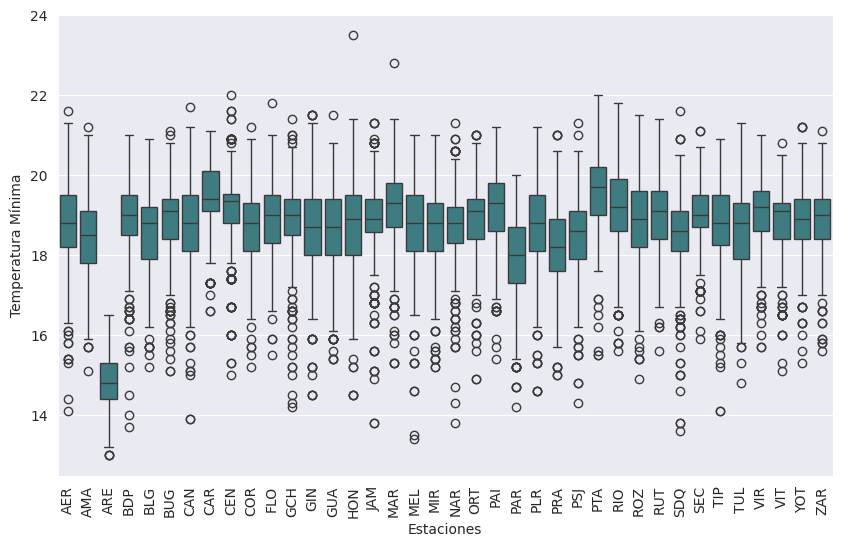

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='tmp_mnma'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Temperatura Mínima por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Temperatura Mínima')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

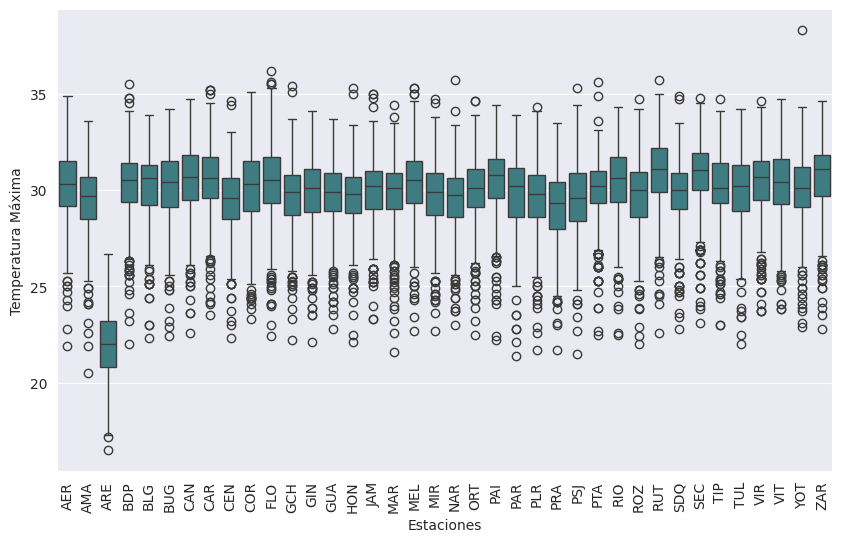

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='tmp_mxma'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Temperatura Máxima por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Temperatura Máxima')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

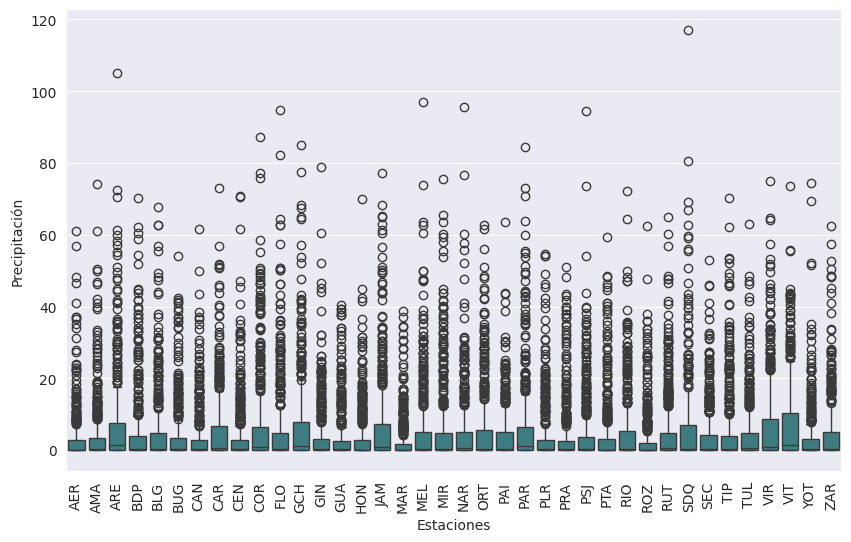

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='prcptcion'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Precipitación por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Precipitación')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

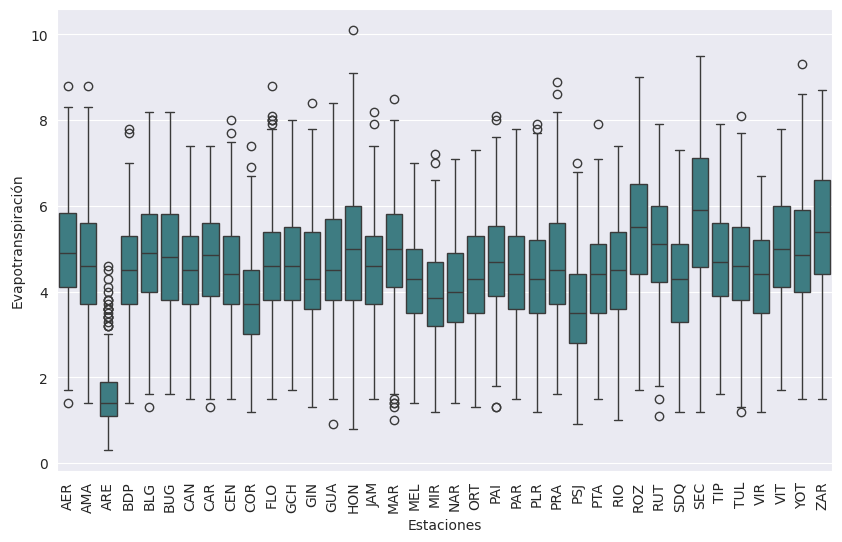

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='etp'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Evapotranspiración por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Evapotranspiración')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

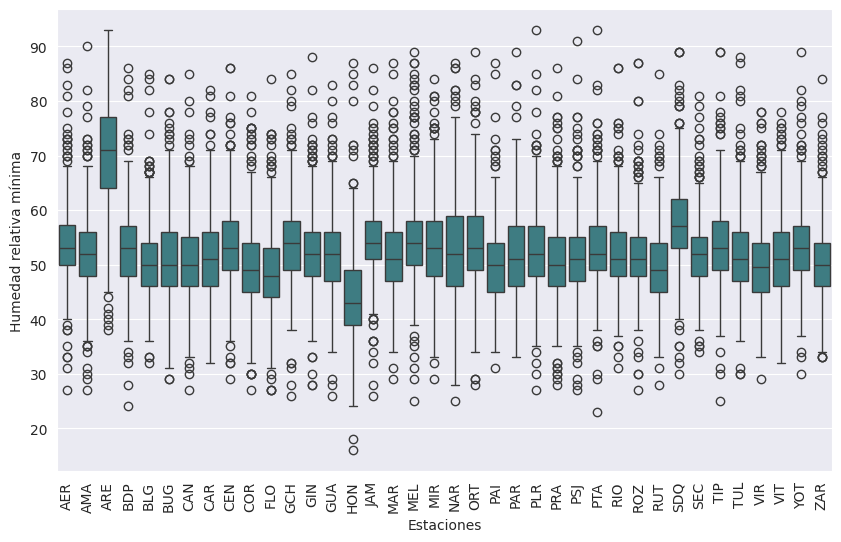

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='hmd_rel_mnma'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Humedad relativa mínima por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Humedad relativa mínima')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

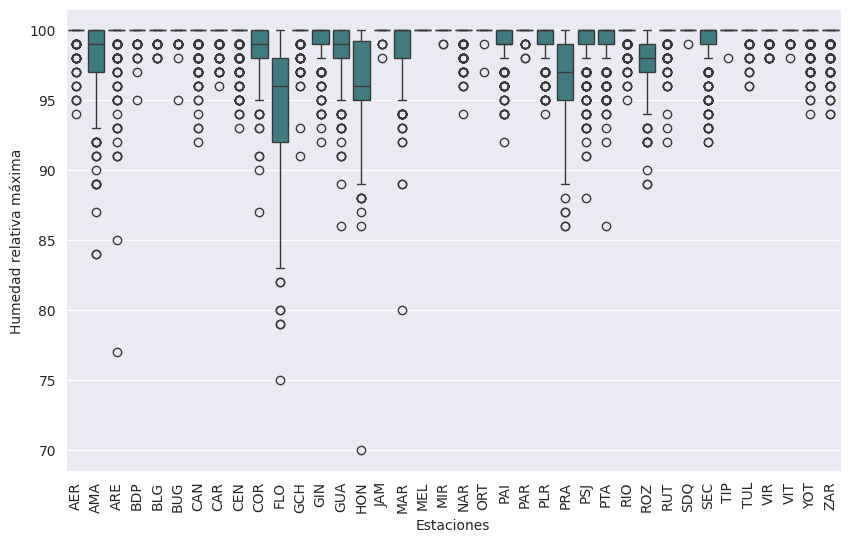

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='hmd_rel_mxma'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Humedad relativa máxima por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Humedad relativa máxima')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

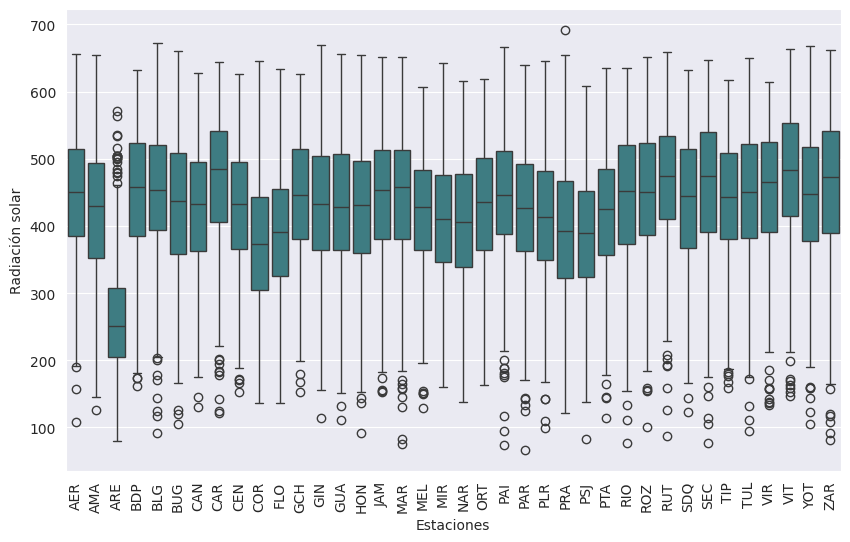

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df, id_vars=['est'], value_vars='rdcion_slar'), x='est', y='value', hue='variable', palette="crest")
#plt.title('Radiación solar por Estación')
plt.xlabel('Estaciones')
plt.ylabel('Radiación solar')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.show()

# Simulación Aquacrop

In [ ]:
# Estaciones disponibles
estaciones = df['est'].unique()

# Dataframe para guardar la simulación
df_prod_final = pd.DataFrame()

for i in tqdm(estaciones, desc="Processing"):
    # Filtrar estaciones
    df_filtrado = df[df['est'] == i].copy()
    # df_filtrado = df_filtrado[df_filtrado['est'] == 'SEC']

    # Asegurarse de que la columna 'Date' esté en formato datetime
    df_filtrado['fc_obsrvcion'] = pd.to_datetime(df_filtrado['fc_obsrvcion'])

    # Crear nuevas columnas en el DataFrame para el año, mes y día
    df_filtrado['Year'] = df_filtrado['fc_obsrvcion'].dt.year
    df_filtrado['Month'] = df_filtrado['fc_obsrvcion'].dt.month
    df_filtrado['Day'] = df_filtrado['fc_obsrvcion'].dt.day

    # Ordenar por fecha
    df_filtrado = df_filtrado.sort_values(by='fc_obsrvcion')

    # Seleccionar solo las columnas deseadas
    columnas_deseadas = ['Day', 'Month', 'Year', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'etp',
                         'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar']

    # Crear un nuevo DataFrame con solo las columnas seleccionadas
    df_filtrado = df_filtrado[columnas_deseadas]

    # Cambiar el nombre de las columnas utilizando un diccionario
    df_filtrado = df_filtrado.rename(columns={'tmp_mnma': 'MinTemp',
                                              'tmp_mxma': 'MaxTemp',
                                              'prcptcion': 'Precipitation',
                                              'etp': 'ReferenceET',
                                              'hmd_rel_mnma': 'MinHmd',
                                              'hmd_rel_mxma': 'MaxHmd',
                                              'rdcion_slar': 'Radsolar',
                                              'fc_obsrvcion': 'Date'})

    # Restablecer índice
    df_filtrado.reset_index(drop=True, inplace=True)

    ################ Preparar el clima ################

    # Poner las fechas del clima en formato de fecha y hora
    df_filtrado["Date"] = pd.to_datetime(df_filtrado[["Year", "Month", "Day"]])

    # Eliminar las columnas de día, mes y año
    df_filtrado = df_filtrado.drop(["Day", "Month", "Year"], axis=1)

    # Restablecer índice
    df_filtrado.reset_index(drop=True, inplace=True)

    # Establezca un límite en ET0 para evitar errores de división por cero
    df_filtrado.ReferenceET.clip(lower=0.1, inplace=True)

    # Eliminar duplicados por fecha si los hay
    df_filtrado.drop_duplicates(['Date'], keep='last', inplace=True)

    # Encontrar el período secuencial más largo disponible
    result = find_longest_sequential_period(df_filtrado, 'Date')

    # Fecha de inicio y fin de simulación
    start_sim = result[0]
    end_sim = result[1]

    # Dataframe filtrado
    df_sim_filt = df_filtrado[(df_filtrado['Date'] >= start_sim) &
                              (df_filtrado['Date'] <= end_sim)]

    # Expandir el dataframe a 365 días
    df_sim = expand_to_365(df_sim_filt, 'Date')
    #df_sim = fill_date_gaps(df_filtrado, "Date")

    ################ Suelo ################

    #type_soil = choice(['SandyLoam', 'SiltClay', 'Clay', 'Loam', 'SandyClayLoam', 'SiltClayLoam',
    #             'ClayLoam', 'SiltLoam', 'Silt'])
    type_soil = choice(['SandyLoam', 'SiltClay', 'Clay', 'SiltClayLoam', 'ClayLoam'])
    sandy_loam = Soil(soil_type=type_soil)

    ################ Cultivo ################

    plant_date = df_sim['Date'].min().strftime('%m/%d')
    harv_date = df_sim['Date'].max().strftime('%m/%d')

    sugarcane = Crop('SugarCane', planting_date=plant_date, harvest_date=harv_date)

    ################ Contenido inicial de agua ################

    InitWC = InitialWaterContent(value=['FC'])

    ################ Modelo ################

    # Modelo de aquacrop y especificación de fecha de inicio y finalización de la simulación
    model = AquaCropModel(sim_start_time=df_sim['Date'].min().strftime('%Y/%m/%d'),
                          sim_end_time=df_sim['Date'].max().strftime('%Y/%m/%d'),
                          weather_df=df_sim,
                          soil=sandy_loam,
                          crop=sugarcane,
                          initial_water_content=InitWC,
                          irrigation_management=IrrigationManagement(irrigation_method=1),
                          groundwater=GroundWater(method='Constant', values=[2]),
                          field_management=FieldMngt(mulches=True, mulch_pct=100))

    # Ejecutar el modelo hasta su terminación
    model.run_model(till_termination=True)

    # Calcular el mínimo, máximo y promedio general de las variables necesarias
    df_statistics = df_sim[['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET', 'MinHmd', 'MaxHmd', 'Radsolar']]
    overall_min = df_statistics.min().to_frame().T.add_suffix('_min')
    overall_max = df_statistics.max().to_frame().T.add_suffix('_max')
    overall_mean = df_statistics.mean().to_frame().T.add_suffix('_mean')

    # Concatenar los resultados en un único dataframe
    overall_stats = pd.concat([overall_min, overall_max, overall_mean], axis=1)

    # Encuentra la fecha máxima y resta tres meses para obtener la fecha de inicio del último trimestre
    last_quarter_start = df_sim['Date'].max() - pd.DateOffset(months=3)

    # Filtrar datos del último trimestre
    last_quarter_data = df_sim[df_sim['Date'] >= last_quarter_start]

    # Calcular estadísticas generales del último trimestre
    df_last_quarter_data = last_quarter_data[['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET',
                                              'MinHmd', 'MaxHmd', 'Radsolar']]
    last_quarter_min = df_last_quarter_data.min().to_frame().T.add_suffix('_last_quarter_min')
    last_quarter_max = df_last_quarter_data.max().to_frame().T.add_suffix('_last_quarter_max')
    last_quarter_mean = df_last_quarter_data.mean().to_frame().T.add_suffix('_last_quarter_mean')

    # Concatenar los resultados en un único dataframe
    last_quarter_stats = pd.concat([last_quarter_min, last_quarter_max, last_quarter_mean], axis=1)

    # Dataframe resultados aquacrop
    prod_potencial = pd.DataFrame({'estacion': i,
                                   'start_date': df_sim['Date'].min().strftime('%Y/%m/%d'),
                                   'harvest_date': model.get_simulation_results()['Harvest Date (YYYY/MM/DD)'],
                                   'harvest_steps': model.get_simulation_results()['Harvest Date (Step)'],
                                   'dry_yield': model.get_simulation_results()['Dry yield (tonne/ha)'],
                                   'fresh_yield': model.get_simulation_results()['Fresh yield (tonne/ha)'],
                                   'yield_potencial': model._outputs.final_stats['Yield potential (tonne/ha)'],
                                   'seasonal_irrigation': model._outputs.final_stats['Seasonal irrigation (mm)'],
                                   'type_soil': type_soil})

    # Concatenar toda la información calculada
    prod_potencial = pd.concat([prod_potencial, overall_stats, last_quarter_stats], axis=1)

    # Dataframe final
    df_prod_final = pd.concat([df_prod_final, prod_potencial])
    df_prod_final = df_prod_final[~df_prod_final['fresh_yield'].isna()]

Processing: 100%|██████████████████████████████████████████████████████████████████████| 38/38 [00:15<00:00,  2.46it/s]


In [ ]:
print(df_prod_final.shape)
df_prod_final

(38, 51)


,estacion,start_date,harvest_date,harvest_steps,dry_yield,fresh_yield,yield_potencial,seasonal_irrigation,type_soil,MinTemp_min,...,MinHmd_last_quarter_max,MaxHmd_last_quarter_max,Radsolar_last_quarter_max,MinTemp_last_quarter_mean,MaxTemp_last_quarter_mean,Precipitation_last_quarter_mean,ReferenceET_last_quarter_mean,MinHmd_last_quarter_mean,MaxHmd_last_quarter_mean,Radsolar_last_quarter_mean
0,AER,2021/01/01,2021-12-31,363,31.896284,106.320948,37.188294,2595,SandyLoam,14.1,...,74.0,100.0,655.3,18.711828,30.389247,3.827957,5.416129,52.634409,99.870968,465.059140
0,AMA,2021/01/01,2021-12-31,363,1.852373,6.174578,NaN,795,Clay,15.1,...,67.0,100.0,640.9,18.291398,29.736559,4.289247,5.154839,50.698925,98.397849,443.680645
0,ARE,2021/02/09,2022-02-08,363,1.544685,5.148951,32.954117,210,Clay,13.0,...,85.0,100.0,571.8,14.794624,22.234409,6.087097,1.770968,66.172043,98.946237,288.890323
0,BDP,2021/01/01,2021-12-31,363,1.822973,6.076578,37.189806,675,Clay,13.7,...,64.0,100.0,632.5,18.604301,30.777419,5.004301,4.945161,50.741935,99.978495,474.696774
0,BLG,2021/01/01,2021-12-31,363,31.903185,106.343950,37.195476,1260,SiltClayLoam,15.2,...,67.0,100.0,651.1,18.138710,30.488172,5.025806,5.250538,49.623656,99.967742,479.743011
0,BUG,2021/01/01,2021-12-31,363,31.903185,106.343950,37.195476,1125,ClayLoam,15.1,...,70.0,100.0,624.6,18.448387,30.472043,4.759140,5.074194,50.096774,100.000000,455.632258
0,CAN,2021/01/01,2021-12-31,363,31.900029,106.333429,37.192096,1095,ClayLoam,13.9,...,68.0,100.0,611.7,18.676344,31.039785,5.234409,4.831183,48.903226,99.849462,453.273118
0,CAR,2021/01/01,2021-12-31,363,31.903185,106.343950,37.195476,1035,ClayLoam,17.3,...,69.0,100.0,641.1,19.306452,30.791398,4.943011,5.047312,50.408602,99.946237,486.931183
0,CEN,2021/01/01,2021-12-31,363,31.897589,106.325295,37.189663,1185,ClayLoam,15.0,...,69.0,100.0,626.2,18.974194,29.841935,2.679570,4.788172,51.731183,99.602151,442.677419
0,COR,2021/03/10,2022-03-09,363,1.817808,6.059360,37.192476,525,Clay,15.2,...,72.0,100.0,564.6,18.605495,30.073626,5.972527,4.046154,47.571429,97.538462,388.165934


In [ ]:
df_prod_final['type_soil'].unique()

array(['SandyLoam', 'Clay', 'SiltClayLoam', 'ClayLoam', 'SiltClay'],
      dtype=object)

# Simulación Aquacrop: Fechas Aleatorias

In [ ]:
# Estaciones disponibles
estaciones = df['est'].unique()

# Dataframe para guardar la simulación
df_prod_final = pd.DataFrame()

# Número de filas a simular para modelo de machine learning
filas = 1000

# Barra de progreso
pbar = tqdm(desc="Generating Data", unit=" iteration", dynamic_ncols=True, leave=True, mininterval=0.5)

# Este flag ayudará a alternar operaciones para extender a 365 días el dataframe, o a 11 meses para info con 10 meses
# de completitud
# previous_transformed = False

# Este contador ayudará a alternar operaciones para extender a 365 días el dataframe, o a 11 meses, o dejar a 10 meses
# la info con hasta 10 meses de completitud
transform_counter = 0

# Este flag ayudará a contar el número de iteraciones necesarias para tener 1000 simulaciones únicas
iteraciones = 0

while len(df_prod_final) < filas:

    # Seleccione una estación al azar
    estacion = choice(list(estaciones))

    # Filtrar estaciones
    df_filtrado = df[df['est'] == estacion].copy()

    # Eliminar una primera observación aleatoria
    obs_index_1 = randint(0, len(df_filtrado)-1)
    df_filtrado.drop(index=df_filtrado.index[obs_index_1], inplace=True)

    # Eliminar una segunda observación aleatoria
    #obs_index_2 = randint(0, len(df_filtrado)-1)
    #df_filtrado.drop(index=df_filtrado.index[obs_index_2], inplace=True)

    # Eliminar una tercera observación aleatoria
    #obs_index_3 = randint(0, len(df_filtrado)-1)
    #df_filtrado.drop(index=df_filtrado.index[obs_index_3], inplace=True)

    # Asegurarse de que la columna 'Date' esté en formato datetime
    df_filtrado['fc_obsrvcion'] = pd.to_datetime(df_filtrado['fc_obsrvcion'])

    # Crear nuevas columnas en el DataFrame para el año, mes y día
    df_filtrado['Year'] = df_filtrado['fc_obsrvcion'].dt.year
    df_filtrado['Month'] = df_filtrado['fc_obsrvcion'].dt.month
    df_filtrado['Day'] = df_filtrado['fc_obsrvcion'].dt.day

    # Ordenar por fecha
    df_filtrado = df_filtrado.sort_values(by='fc_obsrvcion')

    # Seleccionar solo las columnas deseadas
    columnas_deseadas = ['Day', 'Month', 'Year', 'tmp_mnma', 'tmp_mxma', 'prcptcion', 'etp',
                         'hmd_rel_mnma', 'hmd_rel_mxma', 'rdcion_slar']

    # Crear un nuevo DataFrame con solo las columnas seleccionadas
    df_filtrado = df_filtrado[columnas_deseadas]

    # Cambiar el nombre de las columnas utilizando un diccionario
    df_filtrado = df_filtrado.rename(columns={'tmp_mnma': 'MinTemp',
                                              'tmp_mxma': 'MaxTemp',
                                              'prcptcion': 'Precipitation',
                                              'etp': 'ReferenceET',
                                              'hmd_rel_mnma': 'MinHmd',
                                              'hmd_rel_mxma': 'MaxHmd',
                                              'rdcion_slar': 'Radsolar',
                                              'fc_obsrvcion': 'Date'})

    # Restablecer índice
    df_filtrado.reset_index(drop=True, inplace=True)

    ################ Preparar el clima ################

    # Poner las fechas del clima en formato de fecha y hora
    df_filtrado["Date"] = pd.to_datetime(df_filtrado[["Year", "Month", "Day"]])

    # Eliminar las columnas de día, mes y año
    df_filtrado = df_filtrado.drop(["Day", "Month", "Year"], axis=1)

    # Restablecer índice
    df_filtrado.reset_index(drop=True, inplace=True)

    # Establezca un límite en ET0 para evitar errores de división por cero
    df_filtrado.ReferenceET.clip(lower=0.1, inplace=True)

    # Eliminar duplicados por fecha si los hay
    df_filtrado.drop_duplicates(['Date'], keep='last', inplace=True)

    # Encontrar el período secuencial más largo disponible
    result = find_longest_sequential_period(df_filtrado, 'Date')

    # Fecha de inicio y fin de simulación
    start_sim = result[0]
    end_sim = result[1]

    # Dataframe filtrado
    df_sim_filt = df_filtrado[(df_filtrado['Date'] >= start_sim) &
                              (df_filtrado['Date'] <= end_sim)]

    # Calcular el número de meses que están totalmente completados en las fechas disponibles
    complete_months, month_status = count_complete_months(df_sim_filt, 'Date')

    # Se alterna los datos que se completan a 365 días para tener datos simulados variados
    if complete_months > 9:
        if transform_counter == 0:
            # Apply the first transformation
            df_sim = complete_to_11_months(df_sim_filt, 'Date')
        elif transform_counter == 1:
            # Apply the second transformation
            df_sim = expand_to_365(df_sim_filt, 'Date')
        else:
            # Apply the third transformation (replace with your third function)
            df_sim = df_sim_filt.copy()

        # Increment the counter and reset to 0 if it reaches 3
        transform_counter = (transform_counter + 1) % 3
    else:
        df_sim = df_sim_filt.copy()

    if complete_months > 3:
        ################ Suelo ################

        #type_soil = ['SandyLoam', 'SiltClay', 'Clay', 'Loam', 'SandyClayLoam', 'SiltClayLoam',
        #             'ClayLoam', 'SiltLoam', 'Silt']
        type_soil = choice(['SandyLoam', 'SiltClay', 'Clay', 'SiltClayLoam', 'ClayLoam'])
        sandy_loam = Soil(soil_type=type_soil)

        ################ Cultivo ################

        plant_date = df_sim['Date'].min().strftime('%m/%d')
        harv_date = df_sim['Date'].max().strftime('%m/%d')

        sugarcane = Crop('SugarCane', planting_date=plant_date, harvest_date=harv_date)

        ################ Contenido inicial de aguat ################

        InitWC = InitialWaterContent(value=['FC'])

        ################ Modelo ################

        #Modelo de aquacrop y especificación de fecha de inicio y finalización de la simulación
        model = AquaCropModel(sim_start_time=df_sim['Date'].min().strftime('%Y/%m/%d'),
                              sim_end_time=df_sim['Date'].max().strftime('%Y/%m/%d'),
                              weather_df=df_sim,
                              soil=sandy_loam,
                              crop=sugarcane,
                              initial_water_content=InitWC,
                              irrigation_management=IrrigationManagement(irrigation_method=1),
                              groundwater=GroundWater(method='Constant', values=[2]),
                              field_management=FieldMngt(mulches=True, mulch_pct=100))

        # Ejecutar el modelo hasta su terminación
        model.run_model(till_termination=True)

        # Calcular el mínimo, máximo y promedio general de las variables necesarias
        df_statistics = df_sim[['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET', 'MinHmd', 'MaxHmd', 'Radsolar']]
        overall_min = df_statistics.min().to_frame().T.add_suffix('_min')
        overall_max = df_statistics.max().to_frame().T.add_suffix('_max')
        overall_mean = df_statistics.mean().to_frame().T.add_suffix('_mean')

        # Concatenar los resultados en un único dataframe
        overall_stats = pd.concat([overall_min, overall_max, overall_mean], axis=1)

        # Encuentra la fecha máxima y resta tres meses para obtener la fecha de inicio del último trimestre
        last_quarter_start = df_sim['Date'].max() - pd.DateOffset(months=3)

        # Filtrar datos del último trimestre
        last_quarter_data = df_sim[df_sim['Date'] >= last_quarter_start]

        # Calcular estadísticas generales del último trimestre
        df_last_quarter_data = last_quarter_data[['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET',
                                                  'MinHmd', 'MaxHmd', 'Radsolar']]
        last_quarter_min = df_last_quarter_data.min().to_frame().T.add_suffix('_last_quarter_min')
        last_quarter_max = df_last_quarter_data.max().to_frame().T.add_suffix('_last_quarter_max')
        last_quarter_mean = df_last_quarter_data.mean().to_frame().T.add_suffix('_last_quarter_mean')

        # Concatenar los resultados en un único dataframe
        last_quarter_stats = pd.concat([last_quarter_min, last_quarter_max, last_quarter_mean], axis=1)

        # Dataframe resultados aquacrop
        prod_potencial = pd.DataFrame({'estacion': estacion,
                                       'start_date': df_sim['Date'].min().strftime('%Y/%m/%d'),
                                       'harvest_date': model.get_simulation_results()['Harvest Date (YYYY/MM/DD)'],
                                       'harvest_steps': model.get_simulation_results()['Harvest Date (Step)'],
                                       'dry_yield': model.get_simulation_results()['Dry yield (tonne/ha)'],
                                       'fresh_yield': model.get_simulation_results()['Fresh yield (tonne/ha)'],
                                       'yield_potencial': model._outputs.final_stats['Yield potential (tonne/ha)'],
                                       'seasonal_irrigation': model._outputs.final_stats['Seasonal irrigation (mm)'],
                                       'type_soil': type_soil})

        # Concatenar toda la información calculada
        prod_potencial = pd.concat([prod_potencial, overall_stats, last_quarter_stats], axis=1)

        # Dataframe final
        df_prod_final = pd.concat([df_prod_final, prod_potencial])
        df_prod_final = df_prod_final[(~df_prod_final['fresh_yield'].isna())]# &
                                      #(df_prod_final['fresh_yield']>5.5)]

        # Eliminar duplicados si los hay
        df_prod_final.drop_duplicates(['estacion', 'start_date', 'harvest_date'], keep='last', inplace=True)
        df_prod_final.reset_index(drop=True, inplace=True)

        # Incrementar iteraciones totales
        iteraciones += 1

        # Limpiar la salida anterior antes de actualizar
        pbar.clear()

        # Actualizar tqdm con el progreso actual
        pbar.set_postfix(iteration=iteraciones)
        pbar.update(1)

pbar.close()

Generating Data: 1934 iteration [09:31,  3.38 iteration/s, iteration=1934]


In [ ]:
print(df_prod_final.shape)
df_prod_final

(1000, 51)


,estacion,start_date,harvest_date,harvest_steps,dry_yield,fresh_yield,yield_potencial,seasonal_irrigation,type_soil,MinTemp_min,...,MinHmd_last_quarter_max,MaxHmd_last_quarter_max,Radsolar_last_quarter_max,MinTemp_last_quarter_mean,MaxTemp_last_quarter_mean,Precipitation_last_quarter_mean,ReferenceET_last_quarter_mean,MinHmd_last_quarter_mean,MaxHmd_last_quarter_mean,Radsolar_last_quarter_mean
0,ZAR,2021/02/12,2021-11-01,261,24.223509,80.745031,NaN,900,SiltClayLoam,15.8,...,66.0,100.0,661.7,18.752688,30.778495,4.992473,5.956989,48.903226,99.731183,499.762366
1,PLR,2021/01/01,2021-10-31,302,17.997796,59.992653,32.128296,705,SiltClay,14.6,...,69.0,100.0,601.1,18.223656,30.180645,2.741935,4.736559,49.129032,99.279570,423.191398
2,BUG,2021/01/01,2021-08-22,232,21.678900,72.263000,23.773051,870,SiltClayLoam,15.1,...,76.0,100.0,613.9,18.727957,30.311828,3.401075,4.990323,49.827957,99.967742,438.026882
3,ROZ,2021/01/01,2021-10-11,282,26.180118,87.267059,29.740660,1380,SiltClayLoam,14.9,...,66.0,99.0,639.4,18.654839,30.201075,1.579570,5.935484,48.698925,96.720430,474.718280
4,FLO,2021/05/12,2021-11-01,172,0.958638,3.195462,16.603779,390,Clay,15.9,...,68.0,100.0,622.4,18.630108,31.606452,4.147312,4.763441,44.709677,94.129032,385.459140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,PSJ,2021/01/01,2021-11-01,303,17.633434,58.778112,32.248851,630,SiltClay,14.3,...,71.0,100.0,594.6,18.111828,29.830108,3.610753,3.898925,48.849462,99.193548,397.411828
996,RUT,2021/02/26,2021-11-01,247,23.071857,76.906190,25.565370,825,ClayLoam,16.3,...,62.0,100.0,659.6,18.832258,31.219355,5.017204,5.461290,48.247312,99.978495,494.777419
997,NAR,2022/01/01,2022-08-07,217,20.294858,67.649525,22.028212,1035,SandyLoam,16.1,...,76.0,100.0,580.4,18.693548,28.888172,5.278495,3.880645,49.161290,98.795699,388.997849
998,VIT,2021/03/14,2021-11-01,231,21.584798,71.949326,23.653564,1230,SandyLoam,16.0,...,68.0,100.0,656.3,18.605376,30.573118,8.553763,5.178495,49.666667,100.000000,490.559140


In [ ]:
# Descargar el dataframe final
df_prod_final.to_csv(output_path + "df_prod_final_model_1000.csv", header=True, index=False)